## Exercise 1: Neural Networks
*Implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition*

In [1]:
from numpy import *
%pylab inline
import scipy.optimize as op
#import pandas as pd
import os
import scipy.io as sio
from math import *

Populating the interactive namespace from numpy and matplotlib


*Read in data*

In [2]:
data = sio.loadmat('ex4data1.mat')

In [3]:
X = data["X"]
y = data["y"]
shape(X), shape(y)

((5000L, 400L), (5000L, 1L))

In [4]:
numx = 40
numy = 40
numim = numx*numy
numtot = len(y)
population = range(0,numtot)
im_vec = (random.sample(numim)*(numtot)).astype(int)
max(im_vec)
im_vec

array([ 884, 2055,  795, ..., 2756,  464, 4183])

*Visualize handwritten digits*

In [5]:
img_all = zeros((numx*20,numy*20))
for col in range(numx):
    for row in range(numy):
        imnum = row*numx+col
        subim = X[im_vec[imnum],:].reshape(20,20)
        img_all[col*20:(col+1)*20,row*20:(row+1)*20]=subim

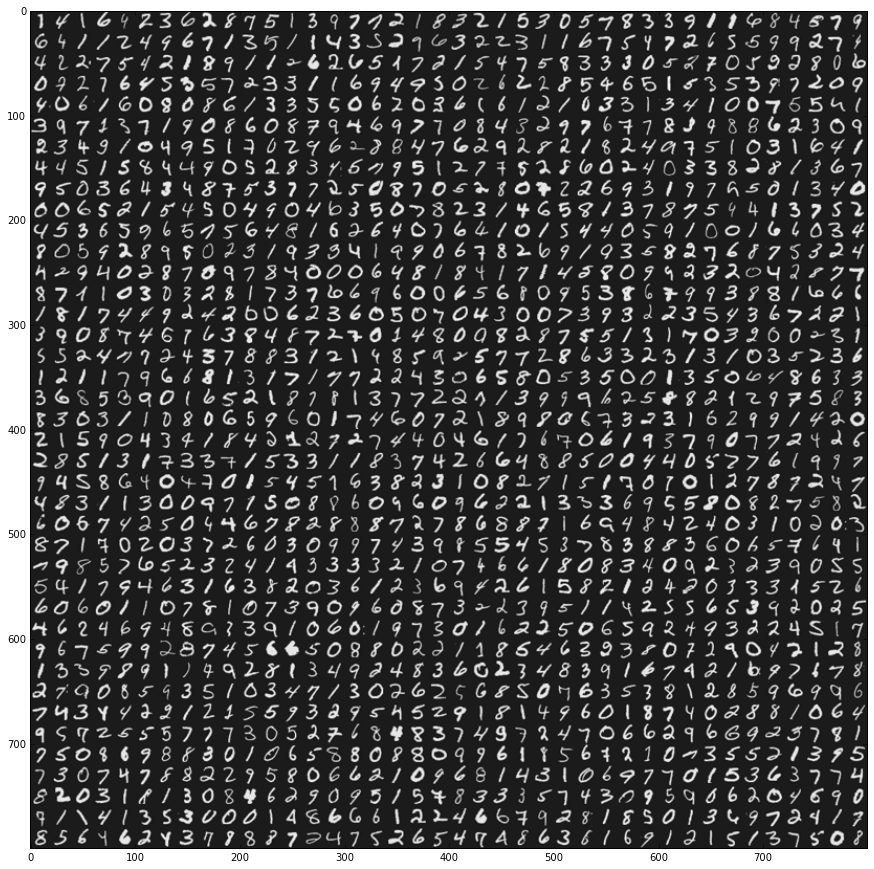

In [6]:
fig = figure(figsize=(15, 15))
implot = imshow(img_all.T)
implot.set_cmap('gray')

*Read in pre-trained weights*

In [7]:
data = sio.loadmat('ex4weights.mat')

*Initialize model parameters*

In [8]:
Theta1 = data["Theta1"]
Theta2 = data["Theta2"]
Theta1.shape, Theta2.shape

((25L, 401L), (10L, 26L))

In [9]:
rows = len(y)

*Define sigmoid function, forward propagate algorithm*

In [10]:
def sigmoid(z):
    g = 1/(1+numpy.exp(-z))
    return g

In [11]:
def forward_propagate(X, Theta1, Theta2):
    
    rows = shape(X)[0]
    
    a1 = insert(X, 0, values=np.ones(rows), axis=1)
    
    z2 = a1 * Theta1.T
    a2 = insert(sigmoid(z2), 0, values=ones(rows), axis=1)
    
    z3 = a2 * Theta2.T
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [12]:
a1, z2, a2, z3, h = forward_propagate(matrix(X),Theta1,Theta2)

*Create vector of digit identities: y_all[:,0] gives the identities of all of the 0's, y_all[:,1] gives all of the 1's...*

In [13]:
y_all = matrix(zeros((rows,10)))
for ii in range(10):
    y_all[:,ii] = (y==ii+1).astype(int)

*neural net cost function*

In [14]:
def nnCostFunction(params, input_size, hidden_size, num_labels, X, y, LR):
    X = matrix(X)
    y = matrix(y)
    m = shape(y)[0]
    
    # unpack nn_params to get Theta1, Theta2
    Theta1 = matrix(reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    Theta2 = matrix(reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    a1, z2, a2, z3, h = forward_propagate(X, Theta1, Theta2)
    
    # loop through each training sample
    cost = 0
    for ii in range(m): 
        cost += -y[ii,:]*numpy.log(h[ii,:].T)-(1-y[ii,:])*numpy.log(1-h[ii,:].T)
    cost = cost/m    
    
    # add regularization outside of loop
    cost += (LR / (2.0 * m)) * (sum(power(Theta1[:,1:], 2)) + sum(power(Theta2[:,1:],2)))
        
    return cost

In [15]:
def sigmoidGradient(z):
    return multiply(sigmoid(z),(1-sigmoid(z)))

*Initialize model weights to a random number between -0.12 and +0.12*

In [16]:
epsilon = 0.12
def InitializeWeights(L_in, L_out):
    epsilon = 0.12
    Wsize = (L_in+1)*L_out
    W = (random.sample(Wsize)-0.5)*epsilon*2.0
    return reshape(W,(L_out,L_in+1))

In [17]:
Theta1_0 = InitializeWeights(400,25)
Theta1_0.shape, Theta1.shape

((25L, 401L), (25L, 401L))

In [18]:
Theta2_0 = InitializeWeights(25,10)
Theta2_0.shape, Theta2.shape

((10L, 26L), (10L, 26L))

*Size of the model. Input layer: 400; hidden layer: 25; output layer (labels):10.*

In [19]:
input_size = 400
hidden_size = 25
num_labels = 10
LR = 3

In [20]:
params = append(Theta1_0.flatten(),Theta2_0.flatten())
params.shape

(10285L,)

In [21]:
cost = nnCostFunction(params, input_size, hidden_size, num_labels, X, y_all, 1)
cost

matrix([[ 7.28355998]])

*Define the back propagation algorithm. Calculates the cost function for certain parameters, and the gradient of the cost function.*

In [22]:
def back_propagate(params, input_size, hidden_size, num_labels, X, y, LR):
    X = matrix(X)
    y = matrix(y)
    m = shape(y)[0]
    
    # unpack nn_params to get Theta1, Theta2
    Theta1 = matrix(reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    Theta2 = matrix(reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    a1, z2, a2, z3, h = forward_propagate(X, Theta1, Theta2)
    Delta1 = matrix(zeros(shape(Theta1)))
    Delta2 = matrix(zeros(shape(Theta2)))
    
    # loop through each training sample
    cost = 0
    for ii in range(m):
        cost += -y[ii,:]*numpy.log(h[ii,:].T)-(1-y[ii,:])*numpy.log(1-h[ii,:].T)
        
        # now do backpropagation to find the gradient
        delta3 = h[ii,:]-y[ii,:]
        delta2 = multiply((delta3*Theta2)[:,1:],sigmoidGradient(z2[ii,:]))
        Delta2 += delta3.T*a2[ii,:]
        Delta1 += delta2.T*a1 [ii,:]   
        
    cost = cost/m    
    
    # add regularization outside of loop
    cost += (LR / (2.0 * m)) * (sum(power(Theta1[:,1:], 2)) + sum(power(Theta2[:,1:],2)))
    
    Delta1 = Delta1/m
    Delta2 = Delta2/m
    
    Delta1[:,1:] += (Theta1[:,1:] * LR) / m
    Delta2[:,1:] += (Theta2[:,1:] * LR) / m
    
    grad = concatenate((ravel(Delta1),ravel(Delta2)))
        
    return cost, grad

In [23]:
cost, grad = back_propagate(params, input_size, hidden_size, num_labels, X, y_all, LR)

*Find the parameters Theta by minimizing the cost function using minimize. Minimize is not complete after 250 iterations, but still gives pretty good parameters.* 

In [24]:
# minimize the objective function
fmin = op.minimize(fun=back_propagate, x0=params, args=(input_size, hidden_size, num_labels, X, y_all, LR), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

  status: 3
 success: False
    nfev: 250
     fun: matrix([[ 0.57763766]])
       x: array([  4.38386528e-01,   1.51078193e-03,   9.03314506e-04, ...,
        -6.43548014e-03,   1.13456526e+00,  -1.36856128e+00])
 message: 'Max. number of function evaluations reached'
     jac: array([ -3.63919607e-05,   9.06469156e-07,   5.41988704e-07, ...,
         4.64778534e-04,   2.33016346e-04,   1.22274669e-04])
     nit: 23

*Reshape the parameters back into matrices*

In [25]:
fit_params = fmin.x
Theta1_fit = matrix(reshape(fit_params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
Theta2_fit = matrix(reshape(fit_params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

*Check how well the parameters work by running forward propagate with the fit parameters. The model fits 97% of the data.*

In [26]:
a1, z2, a2, z3, h = forward_propagate(X, matrix(Theta1_fit), matrix(Theta2_fit))
label = argmax(h,axis=1)+1
diff = label-y
errs = numpy.nonzero(diff)[1]
(float(5000)-len(errs))/float(5000)*100

97.14

*Compare to the pre-trained parameters.*

In [27]:
a1, z2, a2, z3, h = forward_propagate(X, matrix(Theta1), matrix(Theta2))
label = argmax(h,axis=1)+1
diff = label-y
errs = numpy.nonzero(diff)[1]
(float(5000)-len(errs))/float(5000)*100

97.52

*Visualize the hidden layer.*

In [28]:
numx = 5
numy = 5
img_all = zeros((numx*20,numy*20))
for col in range(numx):
    for row in range(numy):
        imnum = row*numx+col
        subim = Theta1[imnum,:400].reshape(20,20)
        img_all[col*20:(col+1)*20,row*20:(row+1)*20]=subim

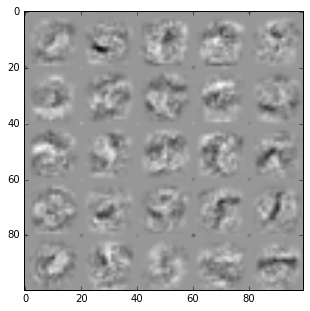

In [29]:
fig = figure(figsize=(5, 5))
implot = imshow(img_all.T)
implot.set_cmap('gray')